In [3]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import sleep
from database.adatabase import ADatabase
from processor.processor import Processor as p
from datetime import datetime

In [4]:
market = ADatabase("market")

In [5]:
russell1000 = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index",attrs={"id":"constituents"})[0]

In [6]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()

In [7]:
sp500.head()

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:
prices = []
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        # data = yf.Ticker(ticker.replace(".","-")).history(start="2015-01-01", end="2025-01-01").reset_index()
        data = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        data["ema"] = data["adjclose"].ewm(span=100, adjust=False).mean() / data["adjclose"]
        prices.append(data)
    except Exception as e:
        print(ticker)
market.disconnect()

 13%|███████████████████████▋                                                                                                                                                                     | 63/503 [00:03<00:19, 22.10it/s]

BRK.B


 16%|█████████████████████████████▎                                                                                                                                                               | 78/503 [00:03<00:19, 21.75it/s]

BF.B


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:26<00:00, 19.01it/s]

ZTS


In [9]:
sim = pd.concat(prices)

In [10]:
sim

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,adjvolume,divcash,splitfactor,ticker,ema
0,2011-01-06,86.14,87.1900,85.630,86.86,3452600,46.985591,47.558320,46.707409,47.378320,4091103,0.00,1.0,MMM,1.000000
1,2011-01-07,86.23,87.3100,85.950,86.55,3355500,47.034682,47.623775,46.881955,47.209228,3976046,0.00,1.0,MMM,0.998977
2,2011-01-10,87.15,87.3300,85.720,85.72,3475200,47.536502,47.634684,46.756500,46.756500,4117882,0.00,1.0,MMM,0.988660
3,2011-01-11,87.74,88.3399,87.330,87.33,3024400,47.858321,48.185540,47.634684,47.634684,3583714,0.00,1.0,MMM,0.982368
4,2011-01-12,88.66,88.7600,87.920,88.02,2732900,48.360141,48.414686,47.956503,48.011049,3238306,0.00,1.0,MMM,0.972726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,2024-12-27,106.87,107.6300,106.260,106.45,743352,106.627206,107.385479,106.018591,106.208160,743352,0.00,1.0,ZBH,1.017391
3517,2024-12-30,105.40,106.3500,104.654,106.05,1531976,105.400000,106.350000,104.654000,106.050000,1531976,0.24,1.0,ZBH,1.028657
3518,2024-12-31,105.63,106.4950,104.960,105.91,683302,105.630000,106.495000,104.960000,105.910000,683302,0.00,1.0,ZBH,1.025895
3519,2025-01-02,104.46,106.6300,104.310,106.47,833938,104.460000,106.630000,104.310000,106.470000,833938,0.00,1.0,ZBH,1.036645


In [11]:
profits = [1.1,1.15,1.2]
stoplosses = [0.97,0.95]

In [12]:
default = {
    "ticker":"",
    "cash":100,
    "quantity":0,
    "adjclose":0,
    "buy_price":0
}

In [13]:
def backtest(sim,profit,stoploss,portfolio):
    results = []
    for date in sim["date"].unique():
        try:
            today = sim[sim["date"]==date]
            if portfolio["ticker"] != "":
                portfolio["date"] = date
                portfolio["adjclose"] = today[today["ticker"]==portfolio["ticker"]]["adjclose"].item()
                pnl = portfolio["adjclose"] / portfolio["buy_price"]
                if pnl >= profit:
                    cash = portfolio["buy_price"] * profit * portfolio["quantity"]
                    portfolio = default.copy()
                    portfolio["cash"] = cash
                    portfolio["date"] = date
                elif pnl <= stoploss:
                    cash = portfolio["buy_price"] * stoploss * portfolio["quantity"]
                    portfolio = default.copy()
                    portfolio["cash"] = cash
                    portfolio["date"] = date
            else:
                if portfolio["cash"] > 0:
                    recommendation = today.sort_values("ema",ascending=False).iloc[0]
                    portfolio["ticker"] = recommendation["ticker"]
                    portfolio["adjclose"] = recommendation["adjclose"]
                    portfolio["buy_price"] = recommendation["adjclose"]
                    portfolio["quantity"] = portfolio["cash"] / portfolio["adjclose"]
                    portfolio["cash"] = 0
            results.append(portfolio.copy())
        except Exception as e:
            print(str(e))
    return results

In [50]:
screener = sim[sim["date"]==sim["date"].unique()[-3]].sort_values("ema",ascending=False).head(5).reset_index()
screener["rank"] = screener.index
screener.merge(sp500,on="ticker",how="left")[["date","rank","ticker","close","ema","GICS Sector"]]

,date,rank,ticker,close,ema,GICS Sector
0,2024-12-31,0,CE,69.21,1.445293,Materials
1,2024-12-31,1,MRNA,41.58,1.424887,Health Care
2,2024-12-31,2,SMCI,30.48,1.400349,Information Technology
3,2024-12-31,3,ENPH,68.68,1.259484,Information Technology
4,2024-12-31,4,CVS,44.89,1.234438,Health Care


In [15]:
analysis = []
for profit in profits:
    for stoploss in stoplosses:
        results = backtest(sim[sim["date"]>=datetime(2020,1,1)].copy(),profit,stoploss,default.copy())
        states = pd.DataFrame(results)
        states["pnl"] = states["cash"] + states["adjclose"] * states["quantity"]
        analysis.append(
            {"profit":profit,
            "stoploss":stoploss,
            "pnl":states["pnl"].iloc[-1]}
        )

In [16]:
a = pd.DataFrame(analysis)

In [17]:
a.sort_values("pnl",ascending=False)

,profit,stoploss,pnl
3,1.15,0.95,1385.021830
2,1.15,0.97,898.120315
1,1.10,0.95,335.918383
0,1.10,0.97,322.948848


In [44]:
profit = 1.15
stoploss = 0.95
results = backtest(sim[sim["date"]>=datetime(2020,1,1)],profit,stoploss,default.copy())

In [45]:
states = pd.DataFrame(results)
states["pnl"] = states["cash"] + states["adjclose"] * states["quantity"] - 100
states["date"] = pd.to_datetime(states["date"])
states.dropna(inplace=True)

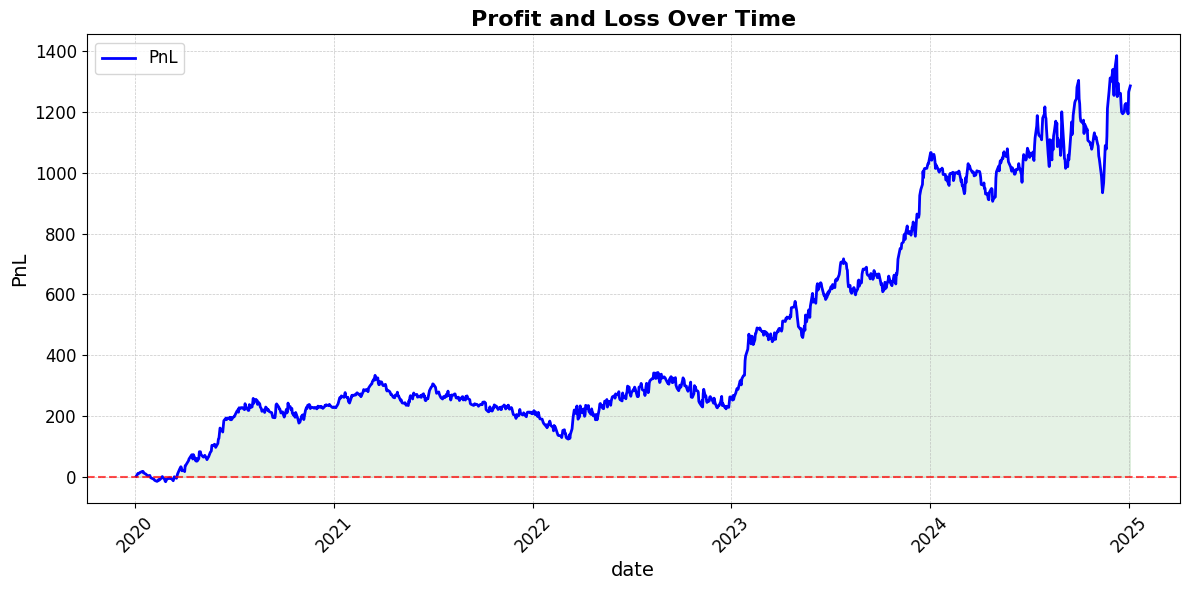

In [46]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(states["date"], states["pnl"], label="PnL", color="blue", linestyle="-", linewidth=2)

# Adding titles and labels
plt.title("Profit and Loss Over Time", fontsize=16, fontweight="bold")
plt.xlabel("date", fontsize=14)
plt.ylabel("PnL", fontsize=14)

# Grid for better readability
plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Customizing ticks
plt.xticks(fontsize=12, rotation=45)  # Rotate dates for better readability
plt.yticks(fontsize=12)

# Adding a legend
plt.legend(fontsize=12, loc="best")

# Adding a horizontal line at zero for reference
plt.axhline(0, color="red", linewidth=1.5, linestyle="--", alpha=0.7)

# Adding a shaded area to emphasize regions (optional)
plt.fill_between(states["date"], states["pnl"], where=(states["pnl"] >= 0), color="green", alpha=0.1, interpolate=True)
plt.fill_between(states["date"], states["pnl"], where=(states["pnl"] < 0), color="red", alpha=0.1, interpolate=True)

# Display the plot
plt.tight_layout()
plt.show()

In [47]:
trades = states.groupby(["ticker","buy_price"]).last().reset_index().sort_values("date").reset_index()

In [48]:
trades

,index,ticker,buy_price,cash,quantity,adjclose,date,pnl
0,12,CRWD,49.440000,0.000000,2.022654,55.940000,2020-01-09,13.147249
1,26,EQT,7.916636,0.000000,14.526372,7.793678,2020-01-17,13.213859
2,25,EQT,6.999177,0.000000,15.608979,6.734343,2020-01-23,5.116216
3,24,EQT,6.233051,0.000000,16.651157,6.318176,2020-01-28,5.204932
4,23,EQT,5.854717,0.000000,16.840802,5.580425,2020-02-03,-6.021173
...,...,...,...,...,...,...,...,...
96,86,SMCI,18.010000,0.000000,57.408120,18.580000,2024-11-15,966.642876
97,43,MRNA,37.290000,0.000000,31.885446,41.110000,2024-11-22,1210.810688
98,45,MRNA,42.050000,0.000000,32.517468,40.760000,2024-12-17,1225.411993
99,0,,0.000000,1298.991551,0.000000,0.000000,2024-12-18,1198.991551
